In [36]:
from sklearn.datasets import load_diabetes
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
from pathlib import Path
import yaml
from copy import deepcopy
from sklearn.metrics import mean_squared_error
from JOPLEn.enums import NormType, CellModel
from JOPLEn.singletask import JOPLEn
from JOPLEn.partitioner import (
    VPartition,
    GBPartition,
    RFPartition,
    LinearForestPartition,
)
from pyHSICLasso import HSICLasso
from sklearn.kernel_ridge import KernelRidge
from ccm import ccm
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from nn import NN

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from ax.service.ax_client import AxClient, ObjectiveProperties

import warnings
import logging
from ax.utils.common.logger import ROOT_STREAM_HANDLER

ROOT_STREAM_HANDLER.setLevel(logging.ERROR)
from collections import defaultdict
from sklearn.pipeline import Pipeline
from JOPLEn.st_penalty import (
    SquaredFNorm,
    Group21Norm,
    GroupInf1Norm,
    L1Norm,
    SquaredLaplacian,
    TreeGaussWeight,
    EuclidMultiQuadWeight,
    TreeMultiQuadWeight,
    EuclidGaussWeight,
    LaplacianType,
)
from JOPLEn.st_loss import LogisticLoss, SquaredError


# Hide future warnings because ax uses deprecated functions from pandas
warnings.simplefilter(action="ignore", category=FutureWarning)
# Hide unfixable warning from ax (warns about default behavior but there isn't
# a clear way to turn the warning off)
warnings.simplefilter(action="ignore", category=UserWarning)


LST_DATASETS = [
    "boston",
    "diabetes",
    "riboflavin",
    "pac_dimerization",
    "crime",
    "virus",
]

CACHE_DIR = Path("ax_runs") / "st_selection"
CACHE_DIR.mkdir(parents=True, exist_ok=True)
DS_PATH = Path("..") / "datasets"

PARAM_PATH = Path(".") / "parameters" / "st_selection"
PLOT_PATH = Path(".") / "plots"

In [37]:
model_info = {}

for file in PARAM_PATH.glob("*.yaml"):
    model_info[file.stem] = yaml.safe_load(open(file, "r"))

In [38]:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)


def train_sklearn(
    ModelClass,
    params,
    x_train,
    y_train,
    x_val,
    y_val,
    x_test,
    y_test,
):
    model = Pipeline([("scaler", StandardScaler()), ("model", ModelClass(**params))])
    model.fit(x_train, y_train.flatten())

    return model


def train_lasso(params, x_train, y_train, x_val, y_val, x_test, y_test):
    pipeline = train_sklearn(
        Lasso,
        params,
        x_train,
        y_train,
        x_val,
        y_val,
        x_test,
        y_test,
    )

    sel_model = pipeline.named_steps["model"]

    return {
        "density": float((np.abs(sel_model.coef_) > 0).mean()),
        "train_error": float(rmse(y_train, pipeline.predict(x_train))),
        "val_error": float(rmse(y_val, pipeline.predict(x_val))),
        "test_error": float(rmse(y_test, pipeline.predict(x_test))),
        "model": (sel_model, pipeline),
    }


def dummy_regressor(x_train, y_train, x_val, y_val, x_test, y_test):
    dummy = DummyRegressor(strategy="mean")
    dummy.fit(x_train, y_train.flatten())

    return {
        "train_error": float(rmse(y_train.flatten(), dummy.predict(x_train))),
        "val_error": float(rmse(y_val.flatten(), dummy.predict(x_val))),
        "test_error": float(rmse(y_test.flatten(), dummy.predict(x_test))),
    }


lst_reg_strings = [
    "SquaredFNorm",
    "Group21Norm",
    "GroupInf1Norm",
    "L1Norm",
    "SquaredLaplacian",
]

eval_param_names = [
    "laplacian_type",
    "weight_class",
]


def pop_regularizers(params):
    regularizers = []

    for p in lst_reg_strings:
        reg_params = {}

        for k, v in params.items():
            if k.startswith(p):
                param_name = "_".join(k.split("_")[1:])
                eval_v = eval(v) if param_name in eval_param_names else v
                reg_params[param_name] = eval_v

        if reg_params:
            regularizers.append(eval(p)(**reg_params))

    params = {k: v for k, v in params.items() if k.split("_")[0] not in lst_reg_strings}

    return regularizers, params


def train_joplen(
    params,
    x_train,
    y_train,
    x_val,
    y_val,
    x_test,
    y_test,
):
    fit_params = {"verbose": params.pop("verbose", False)}

    params["partitioner"] = eval(params["partitioner"])
    params["cell_model"] = eval(params.pop("cell_model", "SquaredError"))

    regularizers, params = pop_regularizers(params)

    model = JOPLEn(
        loss_fn=eval(params.pop("loss_fn", "SquaredError")),
        regularizers=regularizers,
        **params,
    )

    history = model.fit(
        x_train,
        y_train,
        val_x=x_val,
        val_y=y_val,
        print_epochs=1,
        **fit_params,
    )

    if any([isinstance(r, Group21Norm) for r in regularizers]):
        fn_mask = lambda w: np.linalg.norm(w[:-1], axis=-1, ord=2)
    elif any([isinstance(r, GroupInf1Norm) for r in regularizers]):
        fn_mask = lambda w: np.max(np.abs(w[:-1]), axis=-1)
    else:
        raise ValueError("Unknown regularizer")

    return {
        "train_error": float(rmse(y_train, model.predict(x_train))),
        "val_error": float(rmse(y_val, model.predict(x_val))),
        "test_error": float(rmse(y_test, model.predict(x_test))),
        "model": model,
        "epochs": len(history),
        "density": float((fn_mask(model.get_weights()) > 0).mean()),
    }


def normalize(x_train, x_val, x_test):
    ss = StandardScaler()

    x_train = ss.fit_transform(x_train)
    x_val = ss.transform(x_val)
    x_test = ss.transform(x_test)

    return x_train, x_val, x_test


def train_hsic(params, x_train, y_train, x_val, y_val, x_test, y_test):
    params = deepcopy(params)

    n_features = int(np.ceil(params.pop("frac_features") * x_train.shape[1]))

    assert n_features > 0, "n_features must be > 0"

    x_train, x_val, x_test = normalize(x_train, x_val, x_test)

    sel_model = HSICLasso()
    sel_model.input(x_train, y_train)
    sel_model.regression(
        n_features,
        max_neighbors=params.pop("max_neighbors"),
        B=params.pop("B"),
        M=params.pop("M"),
    )

    sel_feats = np.array(sel_model.get_index())

    pred_model = KernelRidge(**params)

    pred_model.fit(x_train[:, sel_feats], y_train)
    y_train_pred = pred_model.predict(x_train[:, sel_feats])
    y_val_pred = pred_model.predict(x_val[:, sel_feats])
    y_test_pred = pred_model.predict(x_test[:, sel_feats])

    return {
        "train_error": float(rmse(y_train, y_train_pred)),
        "val_error": float(rmse(y_val, y_val_pred)),
        "test_error": float(rmse(y_test, y_test_pred)),
        "model": (sel_model, pred_model),
        "density": float(n_features / x_train.shape[1]),
    }


def train_ensemble(ModelClass, params, x_train, y_train, x_val, y_val, x_test, y_test):
    params = deepcopy(params)
    n_features = int(np.ceil(params.pop("frac_features") * x_train.shape[1]))

    x_train, x_val, x_test = normalize(x_train, x_val, x_test)

    # select features with highest feature importance
    model = ModelClass(**params)
    model.fit(x_train, y_train)

    sel_features = np.argsort(model.feature_importances_)[-n_features:]

    pred_model = ModelClass(**params)
    pred_model.fit(x_train[:, sel_features], y_train)

    y_train_pred = pred_model.predict(x_train[:, sel_features])
    y_val_pred = pred_model.predict(x_val[:, sel_features])
    y_test_pred = pred_model.predict(x_test[:, sel_features])

    return {
        "train_error": float(rmse(y_train, y_train_pred)),
        "val_error": float(rmse(y_val, y_val_pred)),
        "test_error": float(rmse(y_test, y_test_pred)),
        "model": pred_model,
        "density": float(sel_features.mean()),
    }


def train_rf(params, x_train, y_train, x_val, y_val, x_test, y_test):
    return train_ensemble(
        RandomForestRegressor,
        params,
        x_train,
        y_train,
        x_val,
        y_val,
        x_test,
        y_test,
    )


def train_gb(params, x_train, y_train, x_val, y_val, x_test, y_test):
    return train_ensemble(
        GradientBoostingRegressor,
        params,
        x_train,
        y_train,
        x_val,
        y_val,
        x_test,
        y_test,
    )

In [39]:
def score(dummy_res, model_res):
    return {
        "norm_error": {
            "train": float(model_res["train_error"] / dummy_res["train_error"]),
            "val": float(model_res["val_error"] / dummy_res["val_error"]),
            "test": float(model_res["test_error"] / dummy_res["test_error"]),
        },
    }

#### Methods that don't explicitly choose numbers of features

In [40]:
train_fn = {
    Lasso.__name__: train_lasso,
    JOPLEn.__name__: train_joplen,
    HSICLasso.__name__: train_hsic,
    # ccm.__name__.split(".")[-1]: train_ccm,
    RandomForestRegressor.__name__: train_rf,
    GradientBoostingRegressor.__name__: train_gb,
    # NN.__name__: train_nn,
}


def optimize_model(
    model_info,
    ds_path,
    n_trials,
    minimize,
    loss_type,
    alpha,
    alpha_idx,
):
    ds_name = ds_path.parent.name
    params = model_info["parameters"]

    dir_path = CACHE_DIR / model_info["dir_name"] / ds_name
    exp_path = dir_path / f"experiment_{alpha_idx}.json"
    metadata_path = dir_path / f"metadata_{alpha_idx}.yaml"

    if metadata_path.exists():
        with open(metadata_path, "r") as f:
            metadata = yaml.load(f, Loader=yaml.FullLoader)
        return metadata

    x_train = np.loadtxt(ds_path / "x_train.csv", delimiter=",")
    x_val = np.loadtxt(ds_path / "x_val.csv", delimiter=",")
    x_test = np.loadtxt(ds_path / "x_test.csv", delimiter=",")
    y_train = np.loadtxt(ds_path / "y_train.csv", delimiter=",")
    y_val = np.loadtxt(ds_path / "y_val.csv", delimiter=",")
    y_test = np.loadtxt(ds_path / "y_test.csv", delimiter=",")

    dummy_res = dummy_regressor(
        x_train,
        y_train,
        x_val,
        y_val,
        x_test,
        y_test,
    )

    if not exp_path.exists():
        ax_client = AxClient(
            random_seed=0,
            verbose_logging=False,
        )

        ax_client.create_experiment(
            name=model_info["model"],
            parameters=params,
            objectives={loss_type: ObjectiveProperties(minimize=minimize)},
            overwrite_existing_experiment=True,
        )

        for _ in range(n_trials):
            try:
                round_params, trial_index = ax_client.get_next_trial()
                model_res = train_fn[model_info["model"]](
                    round_params,
                    x_train=x_train,
                    y_train=y_train,
                    x_val=x_val,
                    y_val=y_val,
                    x_test=x_test,
                    y_test=y_test,
                )
                model_score = score(dummy_res, model_res, alpha)
                ax_client.complete_trial(
                    trial_index=trial_index, raw_data=model_score["pareto"]["val"]
                )
            except ValueError as e:
                print(e)
                ax_client.abandon_trial(
                    trial_index=trial_index,
                    reason=str(e),
                )
    else:
        ax_client = AxClient.load_from_json_file(exp_path)

    exp_path.parent.mkdir(parents=True, exist_ok=True)

    ax_client.save_to_json_file(
        filepath=exp_path,
    )

    best_parameters, _ = ax_client.get_best_parameters()

    model_res = train_fn[model_info["model"]](
        best_parameters,
        x_train=x_train,
        y_train=y_train,
        x_val=x_val,
        y_val=y_val,
        x_test=x_test,
        y_test=y_test,
    )
    model_score = score(dummy_res, model_res, alpha)

    model_res.pop("model", None)

    metadata = {
        "alpha": float(alpha),
        "model": {
            "name": model_info["model"],
            "results": model_res,
            "score": model_score,
        },
        "dummy": {
            "name": "DummyRegressor",
            **dummy_res,
        },
    }

    with open(metadata_path, "w") as f:
        yaml.dump(metadata, f)

    return metadata

In [41]:
n_samples = 11
densities = np.linspace(0, 1, n_samples, endpoint=True)
datasets = [DS_PATH / ds / "processed" for ds in LST_DATASETS]

---

#### Methods that explicitly chose numbers of features

In [42]:
def optimize_model(
    model_info,
    ds_path,
    n_trials,
    minimize,
    loss_type,
    reg_idx,
):
    ds_name = ds_path.parent.name
    params = deepcopy(model_info["parameters"])

    dir_path = CACHE_DIR / model_info["dir_name"] / ds_name
    exp_path = dir_path / f"experiment_{reg_idx}.json"
    metadata_path = dir_path / f"metadata_{reg_idx}.yaml"

    if metadata_path.exists():
        with open(metadata_path, "r") as f:
            metadata = yaml.load(f, Loader=yaml.FullLoader)
        return metadata

    x_train = np.loadtxt(ds_path / "x_train.csv", delimiter=",")
    x_val = np.loadtxt(ds_path / "x_val.csv", delimiter=",")
    x_test = np.loadtxt(ds_path / "x_test.csv", delimiter=",")
    y_train = np.loadtxt(ds_path / "y_train.csv", delimiter=",")
    y_val = np.loadtxt(ds_path / "y_val.csv", delimiter=",")
    y_test = np.loadtxt(ds_path / "y_test.csv", delimiter=",")

    dummy_res = dummy_regressor(
        x_train,
        y_train,
        x_val,
        y_val,
        x_test,
        y_test,
    )

    nonfixed_params = [v for v in params if v["type"] != "fixed"]
    if len(nonfixed_params) > 0:
        if not exp_path.exists():
            ax_client = AxClient(
                random_seed=0,
                verbose_logging=False,
            )

            params = deepcopy(params)

            ax_client.create_experiment(
                name=model_info["model"],
                parameters=params,
                objectives={loss_type: ObjectiveProperties(minimize=minimize)},
                overwrite_existing_experiment=True,
            )

            for _ in range(n_trials):
                round_params, trial_index = ax_client.get_next_trial()

                try:
                    model_res = train_fn[model_info["model"]](
                        round_params,
                        x_train=x_train,
                        y_train=y_train,
                        x_val=x_val,
                        y_val=y_val,
                        x_test=x_test,
                        y_test=y_test,
                    )
                    model_score = score(dummy_res, model_res)
                    ax_client.complete_trial(
                        trial_index=trial_index,
                        raw_data=model_score["norm_error"]["val"],
                    )
                except ValueError as e:
                    print(e)
                    ax_client.abandon_trial(
                        trial_index=trial_index,
                        reason=str(e),
                    )
        else:
            ax_client = AxClient.load_from_json_file(exp_path)

        exp_path.parent.mkdir(parents=True, exist_ok=True)

        ax_client.save_to_json_file(
            filepath=exp_path,
        )

        best_parameters, _ = ax_client.get_best_parameters()
    else:
        best_parameters = {v["name"]: v["value"] for v in params}
        metadata_path.parent.mkdir(parents=True, exist_ok=True)

    model_res = train_fn[model_info["model"]](
        best_parameters,
        x_train=x_train,
        y_train=y_train,
        x_val=x_val,
        y_val=y_val,
        x_test=x_test,
        y_test=y_test,
    )

    if "cell_model" in best_parameters:
        best_parameters["cell_model"] = str(best_parameters["cell_model"])
    if "partitioner" in best_parameters:
        best_parameters["partitioner"] = str(best_parameters["partitioner"])

    model_score = score(dummy_res, model_res)

    model_res.pop("model", None)

    metadata = {
        "model": {
            "name": model_info["model"],
            "results": model_res,
            "score": model_score,
        },
        "dummy": {
            "name": "DummyRegressor",
            **dummy_res,
        },
        "params": best_parameters,
    }

    with open(metadata_path, "w") as f:
        yaml.dump(metadata, f)

    return metadata

In [43]:
sweep_params = {
    "joplen_linear_gb_l21L2": {
        "name": "Group21Norm_lam",
        "type": "fixed",
        "value": np.logspace(-8, 3, 20),
        "value_type": "float",
    },
    "joplen_linear_gb_linf1L2": {
        "name": "GroupInf1Norm_lam",
        "type": "fixed",
        "value": np.logspace(-8, 3, 20),
        "value_type": "float",
    },
    "rf": {
        "name": "frac_features",
        "type": "fixed",
        "value": np.linspace(0.01, 1, 20),
        "value_type": "float",
    },
    "gb": {
        "name": "frac_features",
        "type": "fixed",
        "value": np.linspace(0.01, 1, 20),
        "value_type": "float",
    },
    "hsic": {
        "name": "frac_features",
        "type": "fixed",
        "value": np.linspace(0.01, 1, 20),
        "value_type": "float",
    },
    "lasso": {
        "name": "alpha",
        "type": "fixed",
        "value": np.logspace(-8, 3, 20),
        "value_type": "float",
    },
}

In [44]:
def replace_param(params, new_param):
    params = [x for x in params if x["name"] != new_param["name"]]

    params.append(new_param)
    return params

In [45]:
reg_res = defaultdict(lambda: defaultdict(list))

datasets = [DS_PATH / ds / "processed" for ds in LST_DATASETS]

for ds_path in datasets:
    for file_name, init_info in model_info.items():
        info = deepcopy(init_info)
        if file_name not in sweep_params:
            continue

        # if info["model"] == "HSICLasso" and ds_path.parent.name == "virus":
        #     continue

        sweep_param = deepcopy(sweep_params[file_name])
        itr = tqdm(sweep_param["value"])
        for i, value in enumerate(itr):
            if info["model"] not in train_fn:
                continue

            # Not necessary for now, only slows things down
            if file_name not in sweep_params:
                continue

            ds_name = ds_path.parent.name

            params = info["parameters"]
            new_param = deepcopy(sweep_param)
            new_param["value"] = float(value)
            params = replace_param(params, new_param)
            info["parameters"] = params

            model_str = f"{file_name} on {ds_name}"
            itr.set_description(f"Running {model_str : <50}")
            if file_name == "nn":
                continue

            # Special case for virus dataset so it doesn't run out of memory
            if file_name == "hsic" and ds_name == "virus":
                continue  # because it tends to crash
                tmp_params = deepcopy(params)
                for tmp_param in tmp_params:
                    if tmp_param["name"] == "B":
                        tmp_param["value"] = 10

            res = optimize_model(
                info,
                ds_path,
                5,  # TODO: increase this number to 50
                True,
                "rmse",
                f"{i}_{n_samples}",
            )

            if res is not None:
                reg_res[info["name"]][ds_name].append(res)

    # break

feat_reg_res = {k: dict(v) for k, v in reg_res.items()}

Running rf on boston                                      : 100%|██████████| 20/20 [00:00<00:00, 494.42it/s]
Running joplen_linear_gb_l21L2 on boston                  : 100%|██████████| 20/20 [00:00<00:00, 438.75it/s]
Running lasso on boston                                   : 100%|██████████| 20/20 [00:00<00:00, 480.00it/s]
Running joplen_linear_gb_linf1L2 on boston                : 100%|██████████| 20/20 [00:00<00:00, 411.93it/s]
Running gb on boston                                      : 100%|██████████| 20/20 [00:00<00:00, 666.44it/s]
Running hsic on boston                                    : 100%|██████████| 20/20 [00:00<00:00, 685.42it/s]
Running rf on diabetes                                    : 100%|██████████| 20/20 [00:00<00:00, 557.89it/s]
Running joplen_linear_gb_l21L2 on diabetes                : 100%|██████████| 20/20 [00:00<00:00, 532.49it/s]
Running lasso on diabetes                                 : 100%|██████████| 20/20 [00:00<00:00, 670.61it/s]
Running joplen_line

In [46]:
feat_reg_res = {k: dict(v) for k, v in reg_res.items()}

In [47]:
def pareto_front(
    score: np.ndarray, density: np.ndarray
) -> tuple[np.ndarray, np.ndarray]:
    unique_density = np.unique(density)

    pareto_score = []
    pareto_density = []

    for d in unique_density:
        mask = density == d
        pareto_score.append(np.min(score[mask]))
        pareto_density.append(d)

    pareto_score = np.array(pareto_score)
    pareto_density = np.array(pareto_density)

    args = np.argsort(pareto_density)

    return pareto_density[args], pareto_score[args]

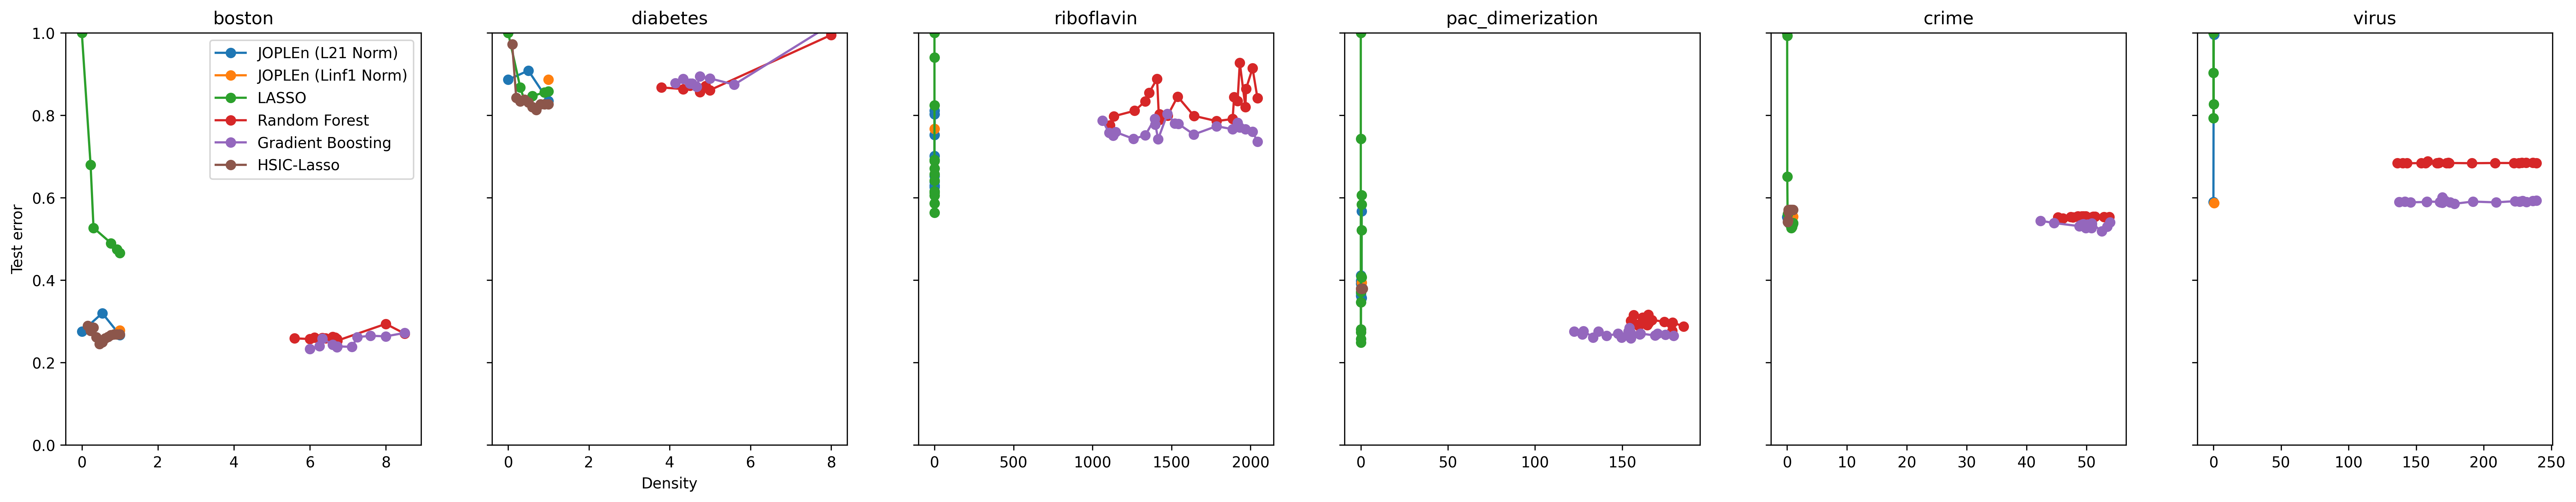

In [52]:
n_ds = len(LST_DATASETS)

sorted_keys = [
    "JOPLEn (L21 Norm)",
    "JOPLEn (Linf1 Norm)",
    "LASSO",
    "Random Forest",
    "Gradient Boosting",
    "CCM",
    "HSIC-Lasso",
]

fig, axs = plt.subplots(1, n_ds, figsize=(5 * n_ds, 5), sharey=True, dpi=300)

for ax, ds in zip(axs, LST_DATASETS):
    for k in sorted_keys:
        if k not in feat_reg_res:
            continue

        if ds not in feat_reg_res[k]:
            continue

        ds_res = feat_reg_res[k][ds]
        model_score = np.array(
            [v["model"]["score"]["norm_error"]["test"] for v in ds_res]
        )
        model_density = np.array([v["model"]["results"]["density"] for v in ds_res])

        pareto_density, pareto_score = pareto_front(model_score, model_density)
        ax.plot(pareto_density, pareto_score, label=k, marker="o")

    ax.set_title(ds)

axs[0].legend()

axs[1].set_xlabel("Density")
axs[0].set_ylabel("Test error")

axs[0].set_ylim(0, 1)

plt.show()

In [49]:
import pandas as pd

shape_dict = {}

for ds in LST_DATASETS:
    ds_path = DS_PATH / ds / "processed"
    x_train = np.loadtxt(ds_path / "x_train.csv", delimiter=",")
    shape_dict[ds] = x_train.shape

shape_dict = pd.DataFrame(
    shape_dict, columns=LST_DATASETS, index=["samples", "features"]
).T
shape_dict

,samples,features
boston,353,13
diabetes,308,10
riboflavin,49,4088
pac_dimerization,73,311
crime,1394,99
virus,2534,479


##### show sparsity pattern

In [50]:
l21_penalties = [
    0.4,
    0.2,
    0.1,
    0.1,
    0.4,
    0.2,
]

linf1_penalties = [
    4.0,
    2.0,
    0.1,
    0.8,
    2.0,
    2.0,
]

weights = {}

for idx, ds in enumerate(LST_DATASETS):
    ds_path = DS_PATH / ds / "processed"

    x_train = np.loadtxt(ds_path / "x_train.csv", delimiter=",")
    y_train = np.loadtxt(ds_path / "y_train.csv", delimiter=",")

    x_train = StandardScaler().fit_transform(x_train)

    model = JOPLEn(
        partitioner=LinearForestPartition,
        n_cells=4,
        n_partitions=10,
        random_state=0,
        cell_model=CellModel.linear,
    )

    _ = model.fit(
        x_train,
        y_train,
        lam=l21_penalties[idx],
        # norm_type=NormType.LINF1,
        norm_type=NormType.L21,
        verbose=False,
    )

    weights[ds] = model.w.get()

misc_data_path = Path() / "misc_data"
misc_data_path.mkdir(parents=True, exist_ok=True)

np.savetxt(
    misc_data_path / "riboflavin_weights.csv",
    weights["riboflavin"],
    delimiter=",",
)

TypeError: JOPLEn.fit() got an unexpected keyword argument 'lam'

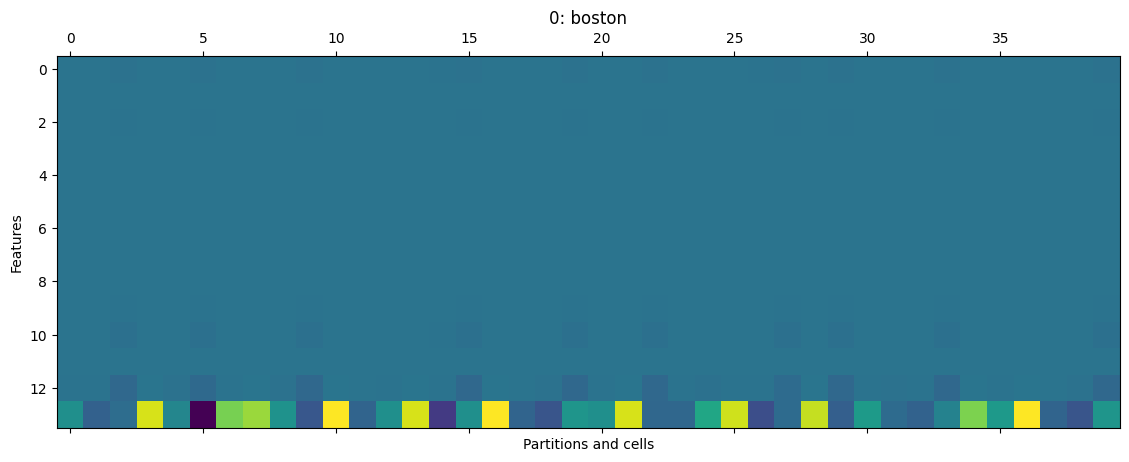

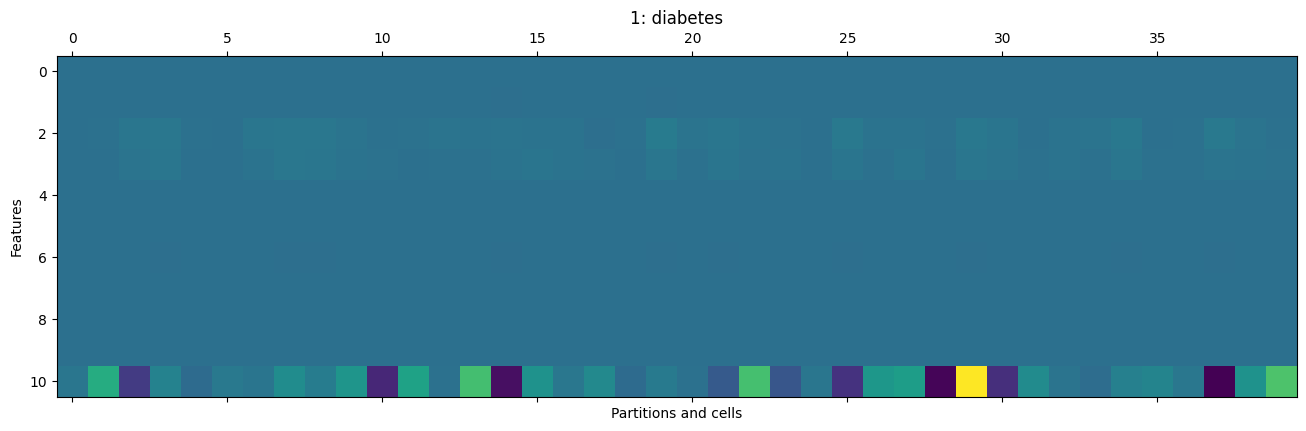

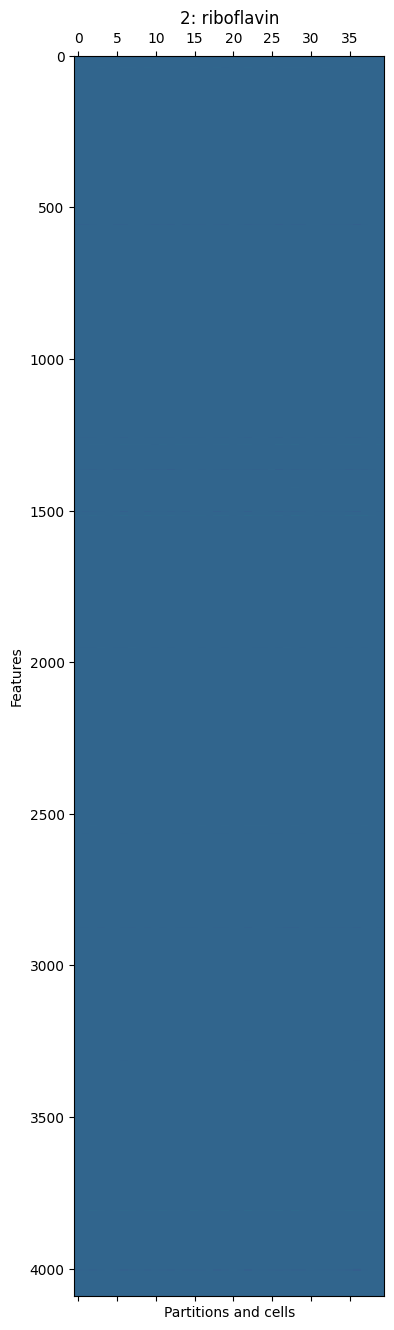

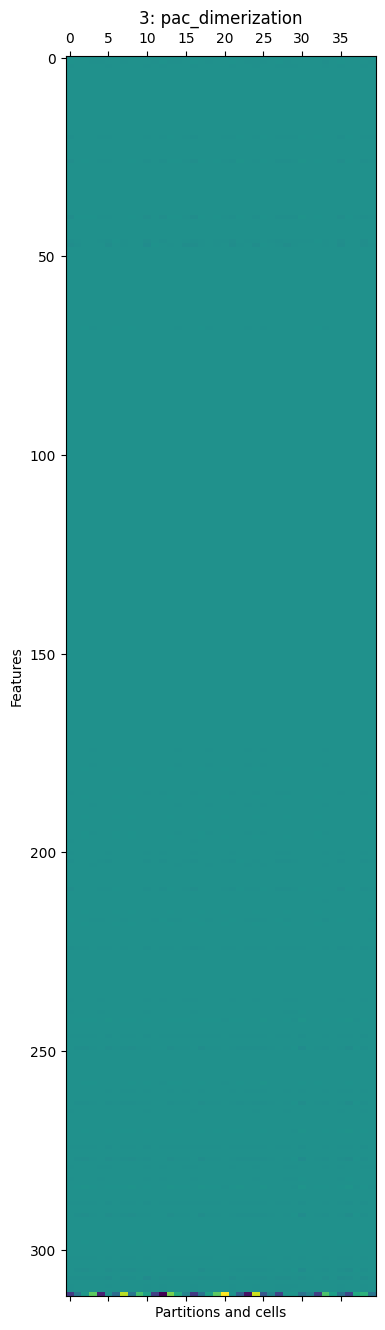

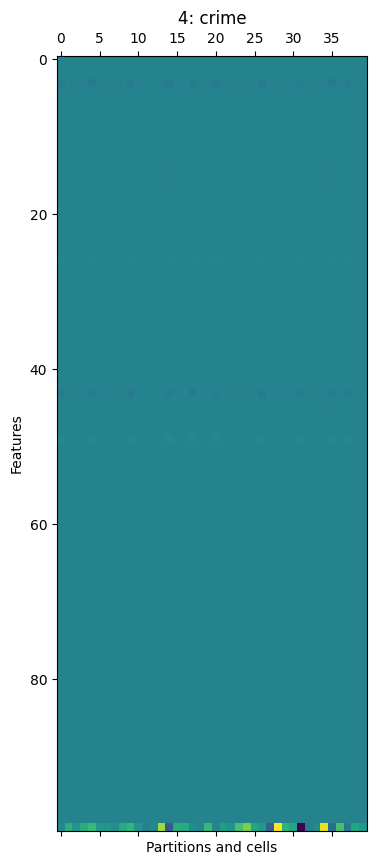

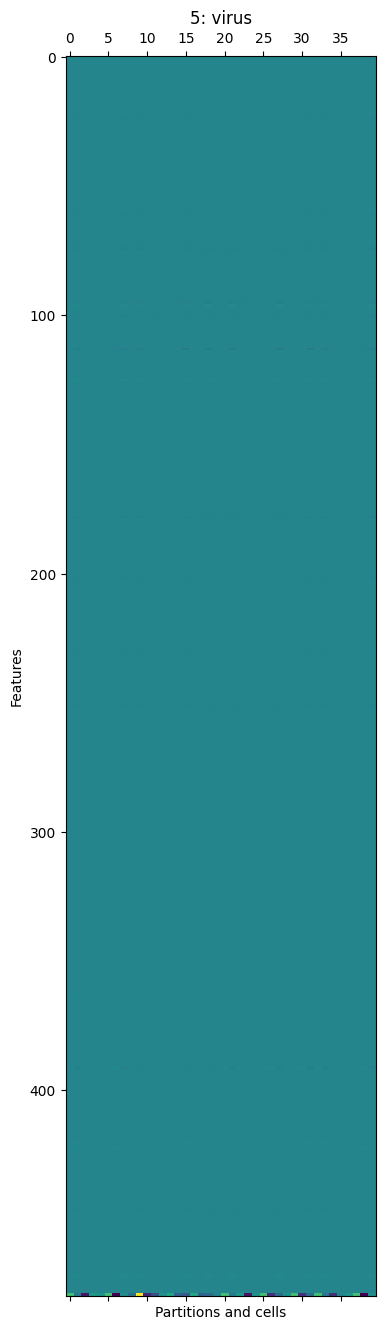

In [ ]:
for i, (name, weight) in enumerate(weights.items()):
    plt.matshow(weight, aspect="auto")
    plt.xlabel("Partitions and cells")
    plt.ylabel("Features")
    plt.title(f"{i}: {name}")
    plt.show()

##### Notes

~~The methods that perform much better all have refitting after the feature selection.
Maybe I should do the same thing with JOPLEn and LASSO.
It could be that the feature penalty is significantly impacting performance because of things like shrinkage.~~

After doing this refitting, JOPLEn seems to perform much better than before.
It seems that the performance of JOPLEn relative to other methods improves as the size of the feature space increases and the number of samples decreases.
Maybe this is because of the partitioning scheme.

It seems like CCM doesn't perform as well as it should.
Maybe this is because it's using kernels for prediction instead of gradient boosting.
Maybe I should rerun it with gradient boosting.